# Climate classification with neural networks

The [Köppen Climate classification](https://en.wikipedia.org/wiki/Köppen_climate_classification) is a widely used climate classification system. It classifies locations around the world as climates like "Tropical rainforest" or "Warm summer continental".

![By Peel, M. C., Finlayson, B. L., and McMahon, T. A.(University of Melbourne)Enhanced, modified, and vectorized by Ali Zifan. - Hydrology and Earth System Sciences: "Updated world map of the Köppen-Geiger climate classification" (Supplement)map in PDF (Institute for Veterinary Public Health)Legend explanation, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=47086879](images/2018-06-11-koppen.png)

(Image from Wikipedia and [1])

One funny thing about the Köppen classification is that it puts Portland, Oregon in the same group as San Francisco and in a very similar group to Los Angeles. I might be wrong,  but Southern California (comfortably walking outside in a t-shirt at 2am) seemed like a pretty different climate than Seattle (not seeing the sun for n months)!

I wanted to try classifying climates of locations. In this post, I'll try to classify the climate of continental US weather stations based on the weather they recorded with the help of a neural net. I'll train a neural net on some task that also helps it learn vector representations for each station. Then I'll cluster the vector representations to cluster similar stations into climate classifications.

## Data

I used data from the [Global Historical Climatology Network](http://doi.org/10.7289/V5D21VHZ) [2, 3]. I used the subset of weather stations from the U.S. Historical Climatology Network.

This gives 2.4G of data containing decades (sometimes over a century!) of daily weather reports from 1,218 stations around the US. It usually gives high temperatures, low temperatures, and precipitation, but also gives information about snow, wind, fog, evaporation rates, volcanic dust, tornados, etc.

### Getting the data

Wheee, let's download a few GBs of historical weather data. 
The [readme](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) is super useful. 
The `tar` file for the US stations is located at `ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd_hcn.tar.gz` (heads up, it uses an underscore, not a hyphen like the readme says!)
The other useful file is `ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt`, which contains coordinates and station names.

### Weather stations

If I go through the `.dly` files in `ghcnd_hcn/` folder, and look up the station names in `ghcnd-stations.txt`, I can plot the stations I have daily weather records for using [Basemap](https://github.com/matplotlib/basemap). (See "Basemap" below for code and details.)

![](images/2018-06-11-stations.png)

In [315]:
from collections import namedtuple
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans

# helper functions you can skip over :D
SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

def hide_ticks(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)        

### Reducing the data

[The script I used for processing data is located here](https://github.com/jessstringham/notebooks/blob/master/scripts/process_weather_data.py).

There are two issues with the dataset: it's a little large to easily load and manipulate in memory and some records are missing or are labeled as low-quality.
I'd love to figure out how to use larger datasets or handle the low-quality data, but I'll save that for another post. 
Instead, I'll create a small subset I can comfortably load into memory. 
For each station, I'll sample up to 2000 daily weather reports, including the maximum temperature, minimum temperature, and precipitation.

I limit the data in a few ways. I dropped data before 1990 to make the datasets more manageable.
I also require all three weather values are not missing and don't have a quality issue.
These may introduce bias. If I was doing real science instead of trying to make a pretty graph, I'd justify these decisions better!

### Loading the dataset

[See `scripts/process_weather_data.py`](https://github.com/jessstringham/notebooks/blob/master/scripts/process_weather_data.py) for details, but if you ran the command in this folder using `data/weather/data` as the output file, such as:

    python scripts/process_weather_data.py [filtered .dly files, see process_weather_data] data/weather/data
    
then I think this code should work.

In [70]:
DATA_PATH = 'data/weather'

matrix_file = os.path.join(DATA_PATH, 'data/gsn-2000-TMAX-TMIN-PRCP.npz')

# column labels
STATION_ID_COL = 0
MONTH_COL = 1
DAY_COL = 2
VAL_COLS_START = 3
TMAX_COL = 3
TMIN_COL = 4
PRCP_COL = 5

with np.load(matrix_file) as npz_data:
    weather_data = npz_data['data'].astype(np.int32)
print(weather_data.shape)

# I decided to switch over to using the day of the year instead of two 
# eh, this isn't perfect (it assumes all months have 31 days), but it helps differentiate 
# the first of the month vs the last. 
weather_data_day_of_year_data = 31 * (weather_data[:, MONTH_COL] - 1) + (weather_data[:, DAY_COL] - 1)

(2417066, 6)


To give an idea of how this data looks, here's the number of examples per station, the minimum and maximum temperature.

There are a few things I'm overlooking for now: the weather report values are always integers and precipitation is always positive. Precipitation has a larger range and is often 0. I'll end up converting the month and day into the approximate day of the year (e.g., 21 = January 21), which means January 1 and December 31 are considered far apart.

1218


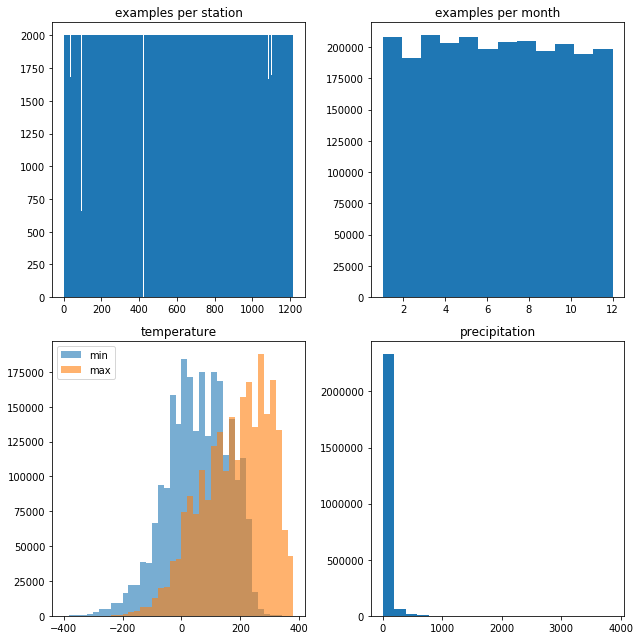

In [319]:
NUM_STATIONS = np.max(weather_data[:, STATION_ID_COL]) + 1
print(NUM_STATIONS)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))

axs[0][0].hist(weather_data[:, STATION_ID_COL], bins=NUM_STATIONS)
axs[0][0].set_title('examples per station')
axs[0][1].hist(weather_data[:, MONTH_COL], bins=12)
axs[0][1].set_title('examples per month')

axs[1][0].hist(weather_data[:, TMIN_COL], bins=range(-400, 400, 20), alpha=0.6, label='min')
axs[1][0].hist(weather_data[:, TMAX_COL], bins=range(-400, 400, 20), alpha=0.6, label='max')
axs[1][0].legend()
axs[1][0].set_title('temperature')
axs[1][1].hist(weather_data[:, PRCP_COL], bins=20)
axs[1][1].set_title('precipitation')

maybe_save_plot('2018-06-11-data')

## Neural network

The purpose of the neural network is to learn a good vector representation of the weather station. To do this, I'll set up a task that hopefully encourages the network to learn a good vector representation.

The inputs are the *station_id* and *day of the year* (so the month and day, but the year is missing).

The network needs to predict the *precipitation*, *high temperature* and *low temperature* for that day. I compare its prediction to an arbitrary year's actual weather and use how poorly it does to tell [TensorFlow](https://www.tensorflow.org) how to update the network parameters.

To get the vector representation, I pass the station_id through an [embedding](https://www.tensorflow.org/programmers_guide/embedding) layer.
Then I concatenate the day to make a bigger vector. I'll pass the station+day vector through a little neural network that needs to predict the three weather values. The full network looks something like this:

![](images/2018-06-11-nn.png)

In the image above, the weather data from U.S. Historical Climatology Network gives me the blue and green boxes. I'm using the blue boxes (station_id and day) as input and the green boxes (precipitation, high temperature, low temperature) as output. As I train the model, backpropagation will find better parameters for the orange boxes (the station vector representations and the neural network.) 

When I'm satisfied, I'll take the vector representation and use an unsupervised classifier on it
I don't particularly care about the neural network learns. I'm just using it to learn the vector representations.
Once I have the vector representations, I'll use [K-Means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to cluster stations that have similar vectors. These clusters will become my climate classification!

In [139]:
# network parameters
BATCH_SIZE = 50
EMBEDDING_SIZE = 20
HIDDEN_UNITS = 40

# and classification parameters. How many climates I want.
CLUSTER_NUMBER = 6


# Tensorflow and classification logs
LOG_PATH = os.path.join(DATA_PATH, 'tf_logs')

TENSORFLOW_SUMMARY_FILE = os.path.join(LOG_PATH, 'tf_summary_{}')
TENSORFLOW_CHECKPOINT_FILE = os.path.join(LOG_PATH, 'model.cpkt')
STATION_CLASSIFICATION_FILE = os.path.join(LOG_PATH, 'station_classification_{run_id}_{step_i}.tsv')

# load the stations file that process_weather_data.py saved. 
# This tells us what the first column's ids map to.
with open(os.path.join(DATA_PATH, 'data/stations') )as f:
    list_of_stations = [line.strip() for line in f.readlines()]

# hiding this code block in blog post

### Defining the network

Below I implement the network in TensorFlow.

In [140]:
tf.reset_default_graph()

# set up the batch and input data
InputBatch = namedtuple('InputBatch', [
    'station_ids',
    'month_day',
])

# let's try out tf.data! set up the dataset and iterator.
with tf.variable_scope('data_loading'):
    station_id_placeholder = tf.placeholder(tf.int32, (None,), name='station_id_placeholder')
    month_day_placeholder = tf.placeholder(tf.float32, (None,), name='month_day_placeholder')  # day of the year
    target_placeholder = tf.placeholder(tf.float32, (None, 3), name='target_placeholder')
    
    dataset = tf.data.Dataset.from_tensor_slices((
        InputBatch(
            station_ids=station_id_placeholder,
            month_day=month_day_placeholder,
        ),
        target_placeholder # and grab all the weather values
    ))\
    .shuffle(buffer_size=10000)\
    .repeat()\
    .batch(BATCH_SIZE)
    
    iterator = dataset.make_initializable_iterator()
    input_batch, targets = iterator.get_next()

# Feed the station id through the embedding. This embeddings variable
# is the whole point of this network!
embeddings = tf.Variable(
    tf.random_uniform(
        [NUM_STATIONS, EMBEDDING_SIZE], -1.0, 1.0),
    dtype=tf.float32,
    name='station_embeddings'
)

embedded_stations = tf.nn.embedding_lookup(embeddings, input_batch.station_ids)

# Drop in the month/day data
station_and_day = tf.concat([
    embedded_stations,
    tf.expand_dims(input_batch.month_day, 1),
], axis=1)

# Now build a little network that can learn to predict the weather
dense_layer = tf.contrib.layers.fully_connected(station_and_day, num_outputs=HIDDEN_UNITS)
with tf.variable_scope('prediction'):
    prediction = tf.contrib.layers.fully_connected(
        dense_layer, 
        num_outputs=3, 
        activation_fn=None, # don't use an activation on prediction
    ) 
    
# Set up loss and optimizer
loss_op = tf.losses.mean_squared_error(prediction, targets)
tf.summary.scalar('loss', loss_op)
train_op = tf.train.AdamOptimizer().minimize(loss_op)

# And additional tensorflow fun things
merged_summaries = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Clustering

As the model is training, I'll occasionally cluster the stations and save the results.

In [141]:
def save_classification(save_location, trained_embeddings):
    kmeans = KMeans(n_clusters=CLUSTER_NUMBER, random_state=0).fit(trained_embeddings)

    with open(save_location, 'w') as f:
        for station, label in zip(stations, kmeans.labels_):
            f.write('{}\t{}\n'.format(station, label))

Now I can start training! You can monitor the job through [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). 

### Deciding when to stop

If I had a metric for how good the climate classifications were, I could use the metric to decide when the model is done training. For the purpose of this post (again, pretty pictures), I'll just train the model long enough to run through the dataset a few times. 

(I have 2.4M weather reports. Since I'm using batch size of 50, it will take around 50K steps will go through the dataset once.)

In [76]:
MAX_STEPS = 1000000
CHECKPOINT_EVERY_N_STEPS = 20000

run_id = int(time.time())
print('starting run {}'.format(run_id))

with tf.Session() as sess:
    sess.run(init)   
    sess.run(iterator.initializer, {
        station_id_placeholder: weather_data[:, STATION_ID_COL],
        month_day_placeholder: weather_data_day_of_year_data,
        target_placeholder: weather_data[:, VAL_COLS_START:],
    })
    
    writer = tf.summary.FileWriter(TENSORFLOW_SUMMARY_FILE.format(run_id), sess.graph)
    
    for step_i in range(MAX_STEPS):
        summary, loss, _ = sess.run([merged_summaries, loss_op, train_op])
        writer.add_summary(summary, global_step=step_i)
        if step_i % CHECKPOINT_EVERY_N_STEPS == 0:
            print('step: {} last loss: {}'.format(step_i, loss))
            saver.save(sess, TENSORFLOW_CHECKPOINT_FILE)
            
            # extract and save the classification
            embedding_values = sess.run(embeddings)
            save_classification(
                STATION_CLASSIFICATION_FILE.format(run_id=run_id, step_i=step_i),
                embedding_values,
            )
            
writer.close()

starting run 1528762114
step: 0 last loss: 18228.15625
step: 20000 last loss: 2900.906494140625
step: 40000 last loss: 4732.07080078125
step: 60000 last loss: 5567.47607421875
step: 80000 last loss: 4267.83740234375
step: 100000 last loss: 4418.9130859375
step: 120000 last loss: 1552.070556640625
step: 140000 last loss: 4438.02490234375
step: 160000 last loss: 9913.9892578125
step: 180000 last loss: 3961.80126953125
step: 200000 last loss: 3075.747802734375
step: 220000 last loss: 4135.208984375
step: 240000 last loss: 3247.721923828125
step: 260000 last loss: 2721.795654296875
step: 280000 last loss: 4562.06396484375
step: 300000 last loss: 3180.221923828125
step: 320000 last loss: 3987.0361328125
step: 340000 last loss: 3438.39453125
step: 360000 last loss: 2264.7490234375
step: 380000 last loss: 2647.287841796875
step: 400000 last loss: 2951.9794921875
step: 420000 last loss: 10272.5322265625
step: 440000 last loss: 2140.482666015625
step: 460000 last loss: 4016.078857421875
step: 4

## Climate!

Here's the last saved figure from a run that used 6 classes.

![](images/2018-06-11-us.png)

Starting with a disclaimer: it's really easy to start seeing patterns in noise!

That said, I think it's neat that places near each other were assigned to the same group! The neural network didn't know about the latitude or longitude of stations, only random weather reports from those stations.

It's also neat that parts of the map look to me like they follow Köppen! The east is split up by latitude into brown, pink, and green. The West coast gets its own and the West gets another.

Though Portland and Seattle still share California's climate. It's also probably weird that the humid South and the arid South West all have the same climate. The Yellow climate also looks a little arbitrary. It doesn't pick up mountains.

## Etc

And that's it! I did a proof of concept of classifying climate with neural nets!
Here are a few other things I found during this project.

### Year-long predictions by climate

The point of this model was to train the embeddings. But the model also learned to predict the weather for each station. For fun, let's check them out.

In [279]:
def predict_a_year(station_ids):
    '''Given a list of station_ids, predict a year of weather for each of them'''
    # shh, just pretend all the months have 31 days
    DAY_COUNT = 31 * 12
    all_days = np.arange(DAY_COUNT)
    
    station_values = []
    with tf.Session() as sess:
        saver.restore(sess, TENSORFLOW_CHECKPOINT_FILE)
        
        for station_id in station_ids:
            station_ids = station_id * np.ones((DAY_COUNT,))
            
            sample_input_batch = InputBatch(
                station_ids=station_ids,
                month_day=all_days,
            )
            
            month_day, pred = sess.run(
                [input_batch.month_day, prediction],
                {input_batch: sample_input_batch}
            )
            
            station_values.append((month_day, pred))
            
    return station_values

# Let's grab all of the stations for each climate. I got these numbers using this script:
#
#     for class_i in {0..5}; do
#         cat tf_logs/station_classification_1528754676_980000.tsv\
#            | awk -F\t -v class=$class_i '{ if ($2 == class) print NR - 1 }' \
#            | paste -s -d"," -;
#     done
#     

In [309]:
PRED_TMAX_COL = 0
PRED_TMIN_COL = 1
PRED_PRCP_COL = 2

stations_per_climate_to_plot = [
    [1,3,42,60,108,111,114,121,125,155,180,181,197,201,280,286,309,310,319,344,346,348,384,386,422,439,495,513,560,601,606,617,664,669,675,676,682,697,704,705,710,716,733,794,796,832,838,895,930,974,981,987,1039,1098,1105,1163,1164,1189,1196],
    [7,12,18,23,25,31,33,35,45,47,50,58,61,62,64,71,80,103,115,116,117,118,120,127,128,129,131,135,137,140,149,154,156,161,164,168,171,183,194,210,213,214,230,232,234,238,239,245,247,251,257,258,259,274,283,297,301,302,313,322,328,336,338,341,342,345,349,351,354,355,357,368,369,381,383,389,391,405,408,411,412,413,416,417,418,423,427,431,433,434,436,446,462,463,467,468,470,471,473,478,480,497,498,509,510,511,530,534,537,542,553,562,564,577,579,585,592,598,603,608,610,615,625,627,628,630,631,632,640,648,665,666,667,670,671,678,679,691,700,713,715,721,722,725,746,755,763,778,780,813,816,817,818,821,828,843,846,852,859,863,870,880,912,917,919,920,921,925,927,932,944,947,952,956,958,959,966,973,990,992,997,1002,1004,1014,1016,1018,1024,1027,1028,1030,1031,1047,1051,1054,1055,1057,1062,1065,1087,1096,1106,1111,1116,1121,1125,1126,1142,1146,1150,1158,1159,1160,1168,1182,1191,1193,1197,1202,1214],
    [22,159,208,248,252,254,256,268,269,281,290,291,318,320,326,329,358,361,367,379,393,400,402,406,419,430,459,474,475,482,483,484,486,489,492,502,508,519,523,524,528,536,555,558,567,574,581,582,593,599,626,633,634,639,642,645,649,650,657,662,677,684,693,695,701,707,709,714,719,728,729,731,732,741,744,761,765,769,770,787,788,793,800,814,819,830,834,835,836,853,855,857,861,862,864,867,875,884,892,894,900,903,908,913,915,916,918,929,941,943,949,953,965,968,978,982,983,988,994,998,1008,1011,1013,1015,1020,1021,1022,1034,1035,1037,1038,1040,1044,1049,1050,1052,1063,1068,1070,1076,1078,1081,1084,1092,1102,1113,1122,1124,1127,1132,1135,1141,1143,1147,1152,1154,1155,1156,1162,1169,1170,1172,1185,1188,1204,1209,1210,1212,1213],
    [0,2,11,15,20,21,27,29,32,34,36,38,40,49,52,56,72,73,79,82,83,84,90,91,94,96,101,102,104,106,132,136,139,142,143,145,148,152,153,162,163,170,172,174,175,177,178,179,186,187,196,198,202,203,204,205,207,209,216,219,221,223,226,227,229,231,235,236,241,242,243,249,250,255,260,263,264,266,270,275,276,277,278,282,284,288,289,292,293,294,295,298,299,305,306,308,312,314,315,317,323,324,325,327,330,332,333,335,337,339,347,352,356,362,363,364,366,374,375,380,385,388,390,392,394,397,398,399,401,403,404,407,409,410,421,424,425,429,435,438,441,447,448,451,452,454,455,456,458,464,465,466,469,472,477,481,485,493,494,496,501,503,504,505,512,515,517,521,522,527,531,533,535,538,540,546,552,556,557,563,568,569,570,573,576,578,580,583,586,587,589,594,595,600,602,604,607,611,612,614,616,620,622,623,635,636,637,641,644,646,651,661,663,668,672,673,674,685,686,688,692,696,698,699,706,708,711,712,718,723,726,727,734,735,737,738,739,743,747,748,751,752,753,757,762,764,766,767,768,772,777,779,781,783,785,791,798,801,802,804,805,810,815,822,826,827,839,841,842,847,851,865,868,873,876,878,879,882,888,889,891,897,898,899,905,907,914,923,924,926,931,933,934,935,940,945,948,951,963,976,977,980,984,989,993,995,996,1006,1007,1029,1032,1033,1041,1042,1043,1056,1059,1061,1067,1074,1079,1080,1088,1091,1094,1095,1097,1099,1100,1101,1107,1110,1115,1130,1131,1133,1134,1140,1144,1149,1157,1166,1179,1180,1183,1184,1190,1195,1199,1200,1203,1208,1211,1216],
    [6,8,9,10,13,14,16,17,19,24,26,37,41,43,44,46,48,51,53,54,57,63,65,67,68,69,75,77,78,81,85,86,87,88,89,92,93,97,99,109,110,112,113,122,126,130,133,134,144,147,151,157,165,169,173,176,182,185,189,190,192,193,195,211,212,217,218,224,228,237,240,265,267,272,279,296,303,304,307,311,321,331,340,350,353,359,360,365,373,378,387,396,414,420,426,437,444,453,457,461,476,487,490,500,507,514,520,526,529,532,539,547,549,554,559,561,575,596,597,605,613,619,629,638,654,655,656,659,660,680,681,683,687,690,702,703,717,736,740,742,749,754,756,759,760,771,782,784,795,803,807,812,823,825,829,831,840,848,850,854,858,881,883,885,886,887,896,901,906,910,911,928,936,937,939,946,950,954,957,961,964,967,970,979,985,999,1000,1001,1003,1005,1009,1010,1012,1019,1025,1026,1045,1046,1048,1053,1064,1069,1071,1072,1073,1075,1077,1085,1089,1093,1104,1109,1112,1114,1117,1120,1123,1128,1129,1136,1137,1138,1139,1145,1148,1161,1165,1171,1174,1175,1176,1177,1181,1186,1187,1192,1194,1205,1206,1207,1217],
    [4,5,28,30,39,55,59,66,70,74,76,95,98,100,105,107,119,123,124,138,141,146,150,158,160,166,167,184,188,191,199,200,206,215,220,222,225,233,244,246,253,261,262,271,273,285,287,300,316,334,343,370,371,372,376,377,382,395,415,428,432,440,442,443,445,449,450,460,479,488,491,499,506,516,518,525,541,543,544,545,548,550,551,565,566,571,572,584,588,590,591,609,618,621,624,643,647,652,653,658,689,694,720,724,730,745,750,758,773,774,775,776,786,789,790,792,797,799,806,808,809,811,820,824,833,837,844,845,849,856,860,866,869,871,872,874,877,890,893,902,904,909,922,938,942,955,960,962,969,971,972,975,986,991,1017,1023,1036,1058,1060,1066,1082,1083,1086,1090,1103,1108,1118,1119,1151,1153,1167,1173,1178,1198,1201,1215],
]
climate_predictions = []
for climate_stations in stations_per_climate_to_plot:
    climate_predictions.append(predict_a_year(climate_stations))
    

climate_id_to_color = ['red', 'blue', 'orange', 'maroon', 'orchid', 'darkcyan']    
    
# hiding this code block in blog post

INFO:tensorflow:Restoring parameters from data/weather/tf_logs/model.cpkt
INFO:tensorflow:Restoring parameters from data/weather/tf_logs/model.cpkt
INFO:tensorflow:Restoring parameters from data/weather/tf_logs/model.cpkt
INFO:tensorflow:Restoring parameters from data/weather/tf_logs/model.cpkt
INFO:tensorflow:Restoring parameters from data/weather/tf_logs/model.cpkt
INFO:tensorflow:Restoring parameters from data/weather/tf_logs/model.cpkt


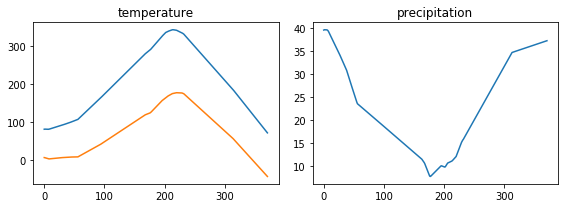

In [318]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

_, arbitrary_station = climate_predictions[0][0]

axs[0].plot(arbitrary_station[:, PRED_TMAX_COL])
axs[0].plot(arbitrary_station[:, PRED_TMIN_COL])
axs[0].set_title('temperature')
axs[1].plot(arbitrary_station[:, PRED_PRCP_COL])
axs[1].set_title('precipitation')

maybe_save_plot('2018-06-11-year-temp-single-pred')
plt.show()

### Predictions by climate

It would be cool to see why the model placed each station in each climate. These graphs are pretty cool, but I wouldn't read too much into them!

I'll group up weather stations by assigned climate, and ask the model to predict the weather every day of the year. Then for each day, I'll plot the prediction of the median of all stations in that climate. To give an idea of the range of predictions in that climate, and shade in the area between the 5th and 95th percentile of stations. 

In other words, on June 11, the precipitation chart will show a solid line where the median of the precipitation predictions for all stations. It shows a shaded region between the 5th and 95th percentile of precipitation predictions. (Note it's not following a particular station! It's just looking at all of the predictions for a day)

#### Temperature

It looks like blue (the West) and maroon (northern part of east of the Rockies) have colder winters.

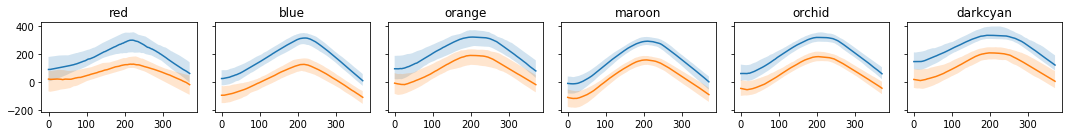

In [320]:
def plot_predictions(climate_predictions, plot_temperature):
    fig, axs = plt.subplots(
        1,
        len(climate_predictions), 
        figsize=(15, 2), 
        sharey=True
    )
    
    for climate_i, climate_pred in enumerate(climate_predictions):
        x_grid = climate_pred[0][0]
        # make a vector of all stations and tranpose so it's day, station, value
        climate_preds = np.vstack((
            [station_data]
            for _, station_data in climate_pred
        ))
            
        central_pred = np.median(climate_preds, axis=0)
        
        lower_bound = np.percentile(climate_preds, q=5, axis=0)
        upper_bound = np.percentile(climate_preds, q=95, axis=0)
        
        if plot_temperature:
            values = [0, 1]
        else:
            values = [2]
            
        for value_i in values:
            axs[climate_i].fill_between(
                x_grid, 
                lower_bound[:, value_i], 
                upper_bound[:, value_i], 
                alpha=0.2, 
                label='two standard deviations'
            )
            
            axs[climate_i].plot(
                x_grid, central_pred[:, value_i]
            )
            
            axs[climate_i].set_title(climate_id_to_color[climate_i])

plot_predictions(climate_predictions, plot_temperature=True)
maybe_save_plot('2018-06-11-year-temp-predictions')
plt.show()

#### Precipitation

I think the precipitation predictions look a little weird. That said, I approve that the red dots were mostly on the West Coast, and the precipitation predictions show that climate includes a lot of places with very rainy winters. And that blue, the West, includes more dry places.

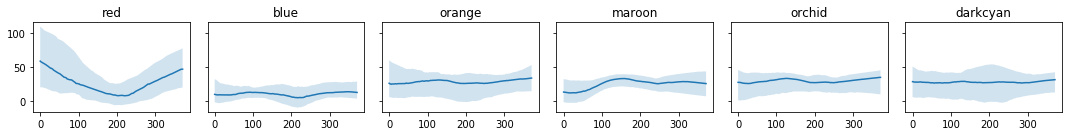

In [321]:
plot_predictions(climate_predictions, plot_temperature=False)
maybe_save_plot('2018-06-11-year-precipitation-predictions')
plt.show()

### TensorBoard Projector

TensorBoard has a neat [embedding](https://www.tensorflow.org/programmers_guide/embedding) visualization currently called Projector. If you add column headers to the tsv files the classifier outputs above, you can load them in as labels and kind of get an idea of what KMeans is doing!

![](images/2018-06-11-tensorboard.png)


### Day of the year

This was funny: before I used the day of the year, I used separate values for the month and the year. Here is what the predictions looked like:

| | | |
|--|--|--|
| ![](images/2018-06-11-silly-nn-1.png) | ![](images/2018-06-11-silly-nn-2.png) | ![](images/2018-06-11-silly-nn-3.png) |

### Basemap

I used Basemap to generate images. Here's some of the [code](https://gist.github.com/jessstringham/319ab3a98d5d35010e1ac870ae2fbff1) I used to generate the maps. 
 
### Inspiration

My sister told me about the problem with Köppen!

The neural network to learn embeddings is a little similar to how [CBOW and Skip-Grams](https://en.wikipedia.org/wiki/Word2vec#CBOW_and_skip_grams) work.

### What next? 

This was a neat proof-of-concept! There are lots of directions one can take this project, but I'm out of time for today. A few off the top of my head are:

 - Use more data!
   - Snow data is often present in the dataset, so I don't even need to deal with missing data.
 - Try different representations of days, like using an embedding!
 - Find a better way to choose the model.

[1] By Peel, M. C., Finlayson, B. L., and McMahon, T. A.(University of Melbourne)Enhanced, modified, and vectorized by Ali Zifan. - Hydrology and Earth System Sciences: "Updated world map of the Köppen-Geiger climate classification" (Supplement)map in PDF (Institute for Veterinary Public Health)Legend explanation, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=47086879

[2] Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview 
of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric 
and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.

[3] Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, 
R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - 
Daily (GHCN-Daily), Version 3. 
NOAA National Climatic Data Center. http://doi.org/10.7289/V5D21VHZ 2018/06/09.